In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime as dt
from scipy.stats import gaussian_kde
from scipy.signal import argrelextrema
import random
import warnings
warnings.filterwarnings('ignore')

## What is KCA?
KCA, or _Kernel Clustering Algorithm_ is a clustering method that relies heavily on the statistical method of a Gaussian Kernel. While Gaussian distributions aren't known for their use in clustering, they can be used as a highly computationally efficient method of extracting one-dimensional clusters. This is because they work cumulatively, cumulating the normal distributions of every point with a fixed bandwidth to produce a simple set of peaks and valleys, the values of which can then be extracted as the centers of their respective clusters. Because Gaussian distributions are trivial to calculate, this also allows KCA to use significantly fewer computational resources than traditional clustering methods. KCA can most easily be used in one-dimensional data, as will be demonstrated here. 

## What are the use cases of KCA?
KCA tends to be a strong algorithm for observing and predicting single-dimensional trends, like purchasing patterns, location frequenting, or any other 'wave-like' behaviors. 

## How is it used here?
The example in this demonstration is a tech company that sells different industrial products to other companies. They sell to 15 companies products from their five separate product lines. The goal is to predict client churn, i.e. which companies have been retained vs which companies have been lost. KCA is extremely appropriate here because the clustering algorithm has to be applied iteratively to each company, as well as each product line, to predict the individual and quasi-independent behaviors.

_Disclaimer: The data being used is a fake dataset generated by ChatGPT, a product of OpenAI._

## Setup
The first two cells are only for the sake of loading the data and adding random variation to it. The data given by ChatGPT was highly regular, and all purchases occurred with exact patterns. The following random variation will somewhat compensate for that, but as we will observe, the data is still somewhat regular. In practice, it tends to be significantly more varied.

In [3]:
# Load in the fake data set
sales_data = pd.read_csv("/Users/lucabutera/Downloads/sales_data_with_categories.csv")

# Convert the 'Order Date' column to datetime object
sales_data['Order Date'] = pd.to_datetime(sales_data['Order Date'])

# Adding variation to the dates so they aren't in such near clusters
# Select random indices to alter:
sample_idx = sales_data.sample(frac=0.15, random_state=42).index

# Convert their data types to integer:
sales_data['Order Date'] = sales_data['Order Date'].astype(int)

# Iterate through the indices to give them a random affect (in units of days)
for i in sample_idx:
    sales_data.iat[i,0] += round(random.triangular(0, 75, 75))*random.choice([-1, 1]) * 86400000000000

# Convert back to datetime objects
sales_data['Order Date'] = pd.to_datetime(sales_data['Order Date'])

In [4]:
# Iterate through each Company/Category Combination to apply a 'stretching factor' (Adding additional variation to the data)
for i in range(15):
    for j in sales_data['Category'].unique():

        data = sales_data[sales_data['Company ID'] == i+1][sales_data['Category'] == j]
        data['Order Date'] = data['Order Date'].astype(int)

        # Find the average of each set. This will act as the 'centering point' of the stretching
        data_avg = np.mean(data['Order Date'])

        # Find each point's distance to the mean, scale it by a random factor between 0 and 1.5, then add it to the original point
        data['Order Date'] = data['Order Date'] + (data['Order Date']-data_avg)*(random.randint(0, 15)/10)

        # Update the original DataFrame
        sales_data['Order Date'][data.index] = pd.to_datetime(data['Order Date'])

### Plotting
Let's first see what the data looks like for one of the categories. We can see that these purchases are somewhat pattenred behavior. This reassures us that KCA will be a strong method for this task.

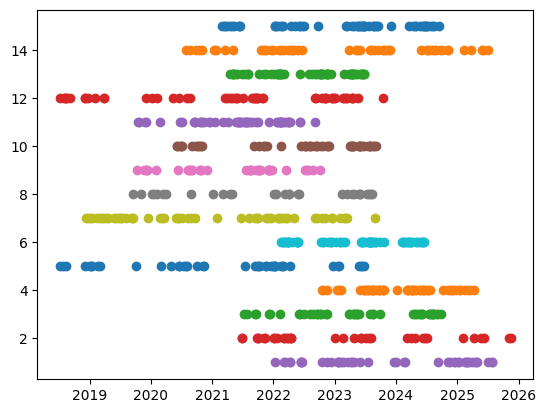

In [5]:
# Iterate through the different companies and observe one category
for i in range(15):
    single_set = sales_data[sales_data['Company ID'] == i+1][sales_data['Category'] == 'Hardware']
    plt.scatter(single_set['Order Date'], np.zeros(len(single_set))+15 - i)

### Experimenting with the data
What will the kernels look like? Where will the peaks be, how far apart, how tall? This plot gives us a picture of what the clustering algorithm will look like. We can see that the data is, even after the random variation, still quite regular. For our purposes, it will suffice. However, this also gives us a picture of how many times this algorithm will need to be run, further justifying the use of KCA in this case.

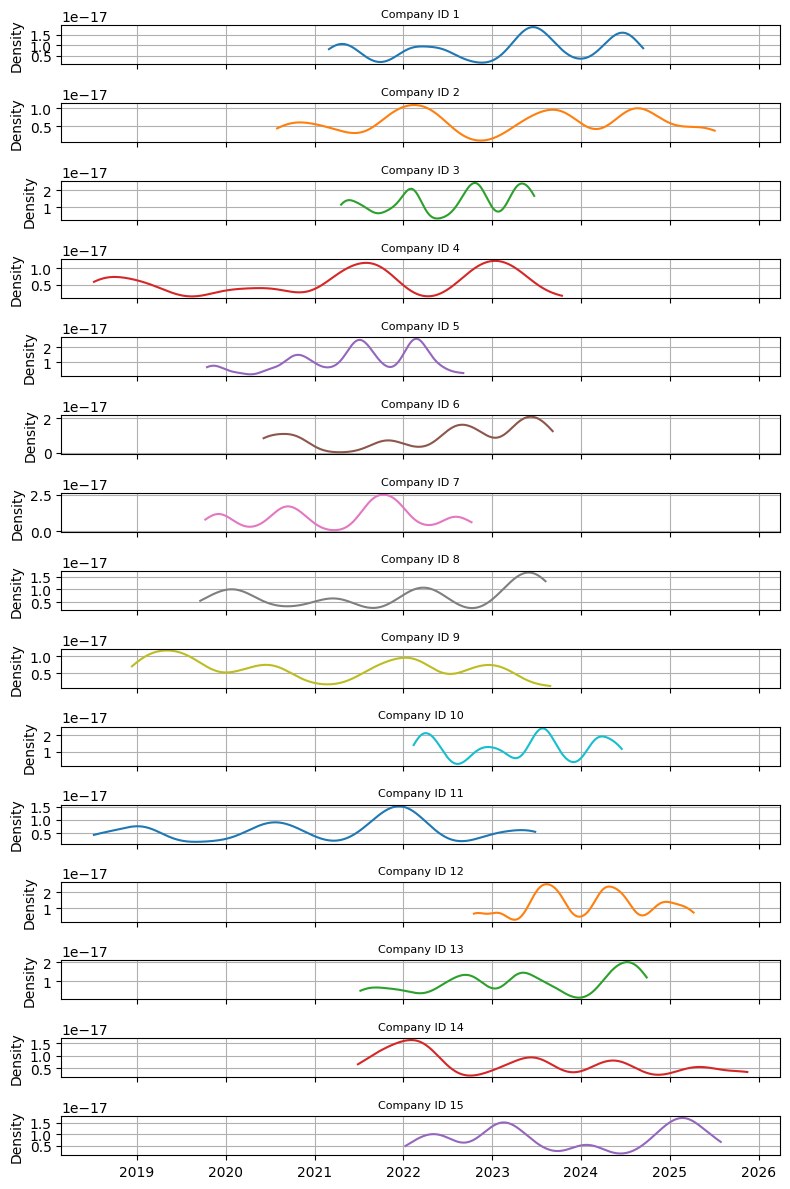

In [6]:
fig, axs = plt.subplots(15, 1, figsize=(8, 12), sharex=True)
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']

# Iterate over each company ID and plot in its subplot
for i in range(15):
    single_set = sales_data[(sales_data['Company ID'] == i+1) & (sales_data['Category'] == 'Hardware')]
    ker = gaussian_kde(single_set['Order Date'].astype(int))
    ker.set_bandwidth(bw_method=ker.factor / 3)
    asints = single_set['Order Date'].astype(int)
    x = np.linspace((asints.min() - 1), (asints.max() + 1), 1000)
    y = ker(x)

    axs[i].plot(pd.to_datetime(x), y, color=colors[i % len(colors)])
    axs[i].set_title(f'Company ID {i+1}', fontsize = 8)
    axs[i].set_ylabel('Density')
    axs[i].grid(True)

plt.tight_layout()

### What are the challenges associated with KCA?
KCA faces two major challenges. The primary of these is the bandwidth challenge. Gaussian kernels rely heavily on their bandwidth parameter, which determines how 'connected' the peaks will be. In some cases of KCA, this parameter can be universally fixed, by typically, it requires dynamic determination. The easiest way to do this is to take 10-20 point sets, and for each, using a pairplot, select an 'ideal' bandwidth that seems to most effectively characterize the clusters. Then, plot this against the number of data points of the series, and run a regression of choice. In every case I have seen, the regression fits very neatly to the points. Then, apply this regression equation to the rest of the series in the `gaussian_kde` function (the default is `1`, or `kde.factor`). 

The second major challenge is the threshold problem. In many cases of KCA, there will be small peaks in very close proximity to larger ones, or peaks that only just barely manage to be peaks at all. Similarly to geology, we define this idea of topographical 'prominence', or the height differential between a peak and the lowest point between it and the next higher peak. This, in practice, I have found to be ideally around 1/10th of the pure height of the tallest peak in the set, although this can once again be determined by the use case.

In [92]:
# The data is cleaned. It is time to perform KCA

x = np.linspace(min(sales_data['Order Date'].astype(int)), max(sales_data['Order Date'].astype(int)), 1000)

Company_data = pd.DataFrame({'Company ID':[], 
                             'Category':[], 
                             'Last Purchase Date':[], 
                             'Next Purchase Date Estimate':[], 
                             'Latest Purchase Before Churn is Likely':[]})

# Iterate through each combination of company and category
for i in range(len(sales_data['Company ID'].unique())):
    for j in sales_data['Category'].unique():
        data = sales_data[sales_data['Company ID'] == i+1][sales_data['Category'] == j]
        data['Order Date'] = data['Order Date'].astype(int)
        if data.shape[0] < 5:
            Company_data.loc[len(Company_data.index)] = [i+1, j, pd.to_datetime(max(x[peak_idx])), np.nan, np.nan]
            continue
        # Initialize the kernel density estimator
        kde = gaussian_kde(data['Order Date'])
        kde.set_bandwidth(bw_method=kde.factor / 3) # This is where you would insert a custom alpha estimating function
        y = kde(x)
        
        # Extract the peaks
        peak_idx = pd.Series(argrelextrema(y, np.greater)[0]).sort_values()
        vall_idx = pd.Series(argrelextrema(y, np.less)[0]).sort_values()
        
        # Check for threshold
        threshold = max(y)/10
        weak_peaks = []

        # Remove any 'valleys' occurring on the tails, since they aren't useful in calculating distance between peaks
        if min(vall_idx) < min(peak_idx):
            vall_idx.drop(vall_idx.index[0])   
        if max(vall_idx) > max(peak_idx):
            vall_idx.drop(vall_idx.index[-1])  
        vall_idx.reset_index(drop=True)

        # Extract the indices facing forward that don't meet the threshold (valleys in front of peaks)
        weak_peaks.extend(np.flatnonzero(abs(y[peak_idx][:-1] - y[vall_idx.sort_values()]) <= threshold))

        # Extract the indices facing backward that don't meet the threshold (valleys behind the peaks)
        weak_peaks.extend(np.flatnonzero(abs(y[peak_idx][1:] - y[vall_idx.sort_values()]) <= threshold)+1)
        
        # Drop the unique indices from the previous extractions
        peak_idx = peak_idx.drop(set(weak_peaks)).reset_index(drop=True)

        # Find the average distance between peaks, and the 90th percentile of distance between peaks
        avg_peak_dist = np.diff(x[peak_idx]).mean()
        percentile_90 = np.quantile(np.diff(x[peak_idx]),0.9)

        # Use the average and 90th percentile distances to estimate the next peak and last peak of retention
        next_peak_estimate = max(x[peak_idx]) + avg_peak_dist
        latest_peak_retention = max(x[peak_idx]) + percentile_90

        Company_data.loc[len(Company_data.index)] = [
                                i+1, 
                                j, 
                                pd.to_datetime(max(x[peak_idx])).round('1d') - np.timedelta64(1, 'D'), 
                                pd.to_datetime(next_peak_estimate).round('1d') - np.timedelta64(1, 'D'), 
                                pd.to_datetime(latest_peak_retention).round('1d') - np.timedelta64(1, 'D')]

In [91]:
# Show the output:

display(Company_data.head(50))

,Company ID,Category,Last Purchase Date,Next Purchase Date Estimate,Latest Purchase Before Churn is Likely
0,1,Hardware,2024-06-19,2025-07-09,2025-08-30
1,1,Sensors,2023-11-01,2024-12-26,2025-02-11
2,1,Tools,2024-01-23,2025-04-06,2025-06-15
3,1,Machines,2025-03-12,2026-03-12,2026-04-16
4,1,Software,2022-09-28,2023-06-14,2023-07-10
5,2,Hardware,2024-08-20,2025-11-26,2026-02-19
6,2,Sensors,2024-11-14,2025-06-26,2025-07-17
7,2,Tools,2024-05-31,2025-02-11,2025-02-25
8,2,Machines,2022-04-01,2023-02-11,2023-04-03
9,2,Software,2023-10-10,2024-06-03,2024-06-18
